In [1]:
# Stiff Robertson's problem from chemical kinetics as in
# https://archimede.uniba.it/~testset/report/rober.pdf
import numpy as np
import matplotlib.pyplot as plt
import time

a = 0.04
b = 1.0e4
c = 3.0e7

# timestep, Tmax, tolearnce for Newton's solver
h = 1.0e-3
Tmax = 1.0e2 # up to 4.0e10
Nsteps = int(np.ceil(Tmax/h))
tol = 1.0e-14
itermax = 20

# initial condition
y0 = np.array([1.0,0.0,0.0])

# the right-hand side
def func(y): 
    dy = np.zeros(3)
    byz = b*y[1]*y[2]
    cy2 = c*y[1]*y[1]
    ax = a*y[0]
    dy[0] = -ax + byz
    dy[1] = ax - byz - cy2
    dy[2] = cy2
    return dy

# the Jacobian matrix for the right-hand side
def Jac(y):
    by = b*y[1]
    bz = b*y[2]
    c2y = 2*c*y[1]
    Jac = np.zeros((3,3))
    Jac[0,0] = -a
    Jac[0,1] = bz
    Jac[0,2] = by
    Jac[1,0] = a
    Jac[1,1] = -bz-c2y
    Jac[1,2] = -by
    Jac[2,1] = c2y
    return Jac


In [2]:
# DIRK2

def NewtonIterDIRK2(y,h,k,gamma):
    aux = y + h*gamma*k
    F = k - func(aux)
    DF = np.identity(3) - h*gamma*Jac(aux)
    return k - np.linalg.solve(DF,F)

def DIRK2step(y,h):
    gamma = 1.0 - 1.0/np.sqrt(2)
    k1 = func(y)
    for j in range(itermax):
        k1 = NewtonIterDIRK2(y,h,k1,gamma)
        if np.linalg.norm(k1 - func(y + h*gamma*k1)) < tol:
            break
    # print( np.linalg.norm(k1 - func(y + h*gamma*k1)))
    # print(j)
    k2 = k1
    y = y + h*(1-gamma)*k1
    for j in range(itermax):
        k2 = NewtonIterDIRK2(y,h,k2,gamma)
        aux = y + h*gamma*k2
        if np.linalg.norm(k2 - func(aux)) < tol:
            break
    # print( np.linalg.norm(k2 - func(aux)))
    # print(j)
    return aux


In [3]:
# solve Robertson's problem

sol = np.zeros((Nsteps+1,3))
t = np.arange(0,(Nsteps+1)*h,h)
sol[0,:] = y0

start_time = time.time()

method_name = "DIRK2"
for j in range(Nsteps): # DIRK2
    sol[j+1,:] = DIRK2step(sol[j,:],h)

end_time = time.time()
t_cpu = end_time - start_time

print(f'method = {method_name:5}, CPUtime = {t_cpu:.6e}')
  

method = DIRK2, CPUtime = 2.133622e+00


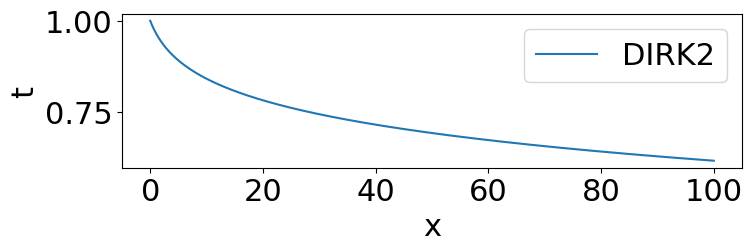

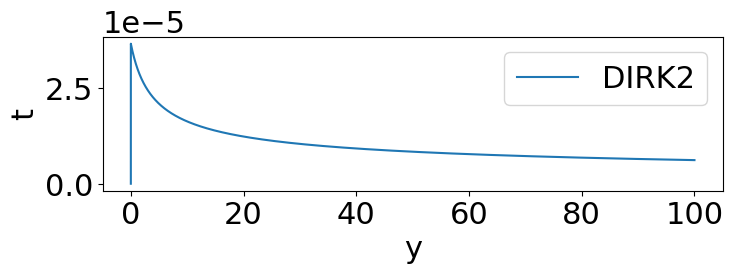

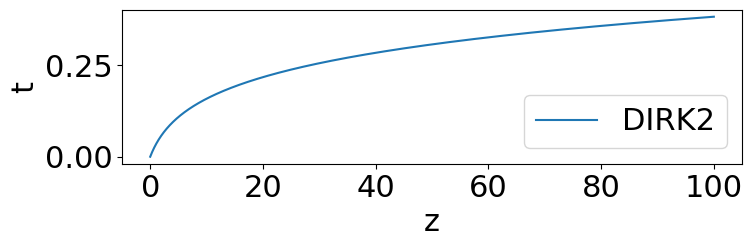

In [4]:
# plot the solution
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(figsize = (8,2))
plt.plot(t,sol[:,0],label = "DIRK2")
plt.xlabel("x")
plt.ylabel("t")
plt.legend()
#plt.xscale("log")
fig, ax = plt.subplots(figsize = (8,2))
plt.plot(t,sol[:,1],label = "DIRK2")
plt.xlabel("y")
plt.ylabel("t")
plt.legend()
#plt.xscale("log")
fig, ax = plt.subplots(figsize = (8,2))
plt.plot(t,sol[:,2],label = "DIRK2")
plt.xlabel("z")
plt.ylabel("t")
plt.legend()
#plt.xscale("log")


In [2]:
# Q3
from math import sin, cos, pi, exp
import numpy as np
import matplotlib.pyplot as plt
import time
# parameter setting

L = 10^4
phi_func = lambda t: sin(t + pi/4)
d_pho_func = lambda t: cos(t + pi/4)

Tmax = 10
gamma = 1.0 - 1.0/np.sqrt(2)
def DIRK2(t, u, h):
    k1 = (-L * (u - phi_func(t + gamma * h)) + d_pho_func(t + gamma * h))/(1 + gamma * h * L)
    k2 = (-L *(u + (1 - gamma) * h * k1 - phi_func(t + h)) + d_pho_func(t + h))/(1 + gamma * h * L)
    u = u + h * (1 - gamma) * k1 + h * gamma * k2

    return u

def DIRK3(t, u, h):

    k1 = (-L * (u - phi_func(t + gamma * h)) + d_pho_func(t + gamma * h))/(1 + gamma * h * L)
    k2 = (-L *(u + (1 - 2 * gamma) * h * k1 - phi_func(t + (1 - gamma) * h)) + d_pho_func(t + (1 - gamma) * h))/(1 + gamma * h * L)
    u = u + h * k1/2 + h * k2/2

    return u

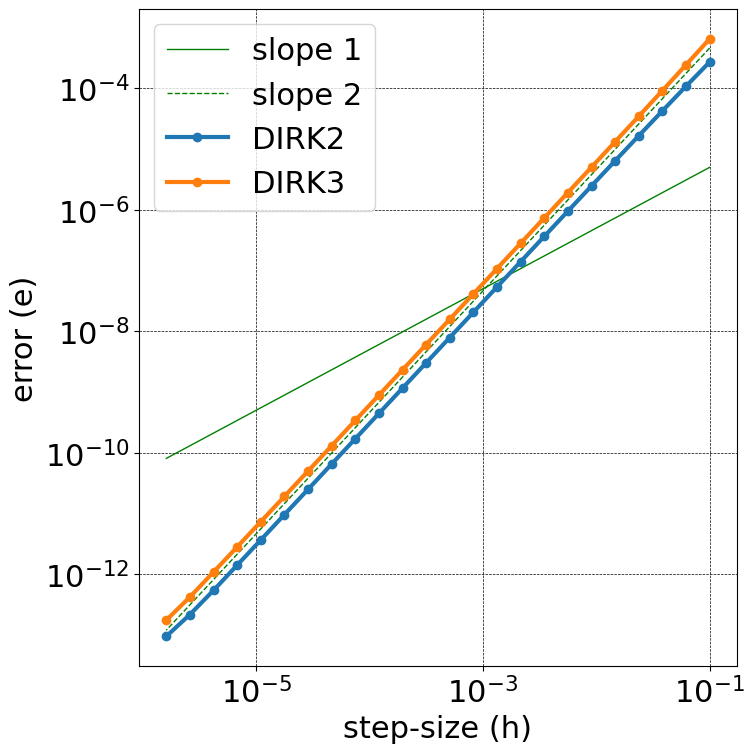

In [6]:
y0 = sin(pi/4)

hs = 10 ** (-np.arange(1,6,5/24))

y = lambda t: exp(-L*t)*(y0 - phi_func(0)) + phi_func(t)

err2 = []
err3 = []

for h in hs:
    times = np.arange(0, Tmax, h)
    y_exc = [y(t) for t in times]
    y_app2 = [y0]
    y_app3 = [y0]
    for i in range(len(times)):
        y_app2.append(DIRK2(times[i], y_app2[-1], h))
        y_app3.append(DIRK3(times[i], y_app3[-1], h))
    err2.append(max([abs(y_app2[i]-y_exc[i]) for i in range(len(times))]))
    err3.append(max([abs(y_app3[i]-y_exc[i]) for i in range(len(times))]))


    # plot
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(figsize=(8,8))
plt.plot(hs, [.00005*h for h in hs],linestyle = '-',color='g', linewidth=1)
plt.plot(hs, [.046*h**2 for h in hs],linestyle = '--',color='g', linewidth=1)
plt.plot(hs,err2, 'o-', linewidth=3)
plt.plot(hs,err3, 'o-', linewidth=3)
plt.xlabel("step-size (h)")
plt.ylabel("error (e)")
plt.xscale('log')
plt.yscale('log')
plt.legend(['slope 1','slope 2','DIRK2','DIRK3'])
plt.grid(color='k', linestyle='--', linewidth=0.5)
plt.tight_layout()
# plt.savefig('Proth_Rob_a.pdf')